In [98]:
import os
import pandas as pd
import numpy as np

csv_dir = "data_chicago_hackathon_2024/probe_data/0"
csv_files = [f for f in os.listdir(csv_dir) if f.endswith('.csv')]
dataframes = [pd.read_csv(os.path.join(csv_dir, f)) for f in csv_files[:2]]  
probe_data = pd.concat(dataframes, ignore_index=True)

roundabout_data = pd.read_csv('data_chicago_hackathon_2024/hamburg_extra_layers/hamburg_rounsabouts.csv')

probe_data.dropna(inplace=True)

max_speeds = probe_data.groupby('traceid')['speed'].max()
pedestrians = max_speeds[max_speeds < 15].index
probe_data = probe_data[~probe_data['traceid'].isin(pedestrians)]

probe_data['heading_change'] = probe_data.groupby('traceid')['heading'].diff().fillna(0).abs() 

In [99]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN

features = probe_data[['latitude', 'longitude', 'heading', 'speed']]
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

epsilon = 0.001  # idk waht to put as epsilon
min_samples = 5
dbscan = DBSCAN(eps=epsilon, min_samples=min_samples)
probe_data['cluster'] = dbscan.fit_predict(scaled_features)

clusters = probe_data[probe_data['cluster'] != -1]

In [100]:
def allfeatures(cluster_df):
    features = {}
    features['mean_heading_change'] = cluster_df['heading_change'].mean()
    features['std_heading_change'] = cluster_df['heading_change'].std()
    features['mean_speed'] = cluster_df['speed'].mean()
    features['std_speed'] = cluster_df['speed'].std()
    features['cluster_size'] = len(cluster_df)
    features['latitude'] = cluster_df['latitude'].mean() 
    features['longitude'] = cluster_df['longitude'].mean() 
    return features

cluster_features = []
for cluster_id, cluster_df in clusters.groupby('cluster'):
    cluster_features.append(allfeatures(cluster_df))

cluster_features_df = pd.DataFrame(cluster_features)

# all the known roundbouts we have
cluster_features_df['is_roundabout'] = 0
for index, roundabout in roundabout_data.iterrows():
    for idx, cluster in cluster_features_df.iterrows():
        distance = np.sqrt((cluster['latitude'] - roundabout['latitude'])**2 + (cluster['longitude'] - roundabout['longitude'])**2)
        if distance < 0.001: #idk waht to put as threshold
            cluster_features_df.at[idx, 'is_roundabout'] = 1

In [103]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# featurebobbing
X = cluster_features_df.drop(['is_roundabout'], axis=1)
y = cluster_features_df['is_roundabout']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       149
           1       1.00      0.67      0.80         3

    accuracy                           0.99       152
   macro avg       1.00      0.83      0.90       152
weighted avg       0.99      0.99      0.99       152



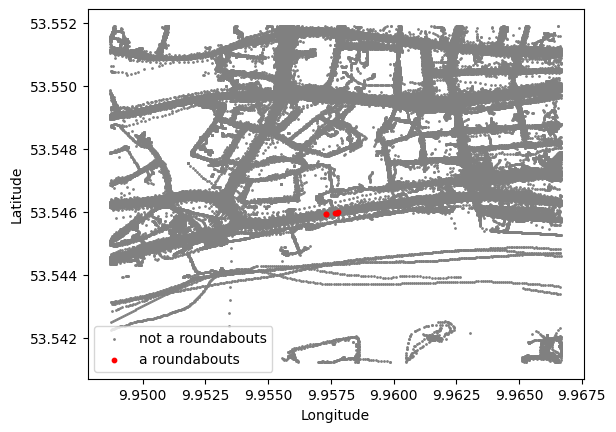

In [104]:
cluster_features_df['predicted_roundabout'] = rf_model.predict(X)
import matplotlib.pyplot as plt

roundabout_clusters = cluster_features_df[cluster_features_df['predicted_roundabout'] == 1]
plt.scatter(probe_data['longitude'], probe_data['latitude'], c='grey', s=1, label='not a roundabouts')
plt.scatter(roundabout_clusters['longitude'], roundabout_clusters['latitude'], c='red', s=10, label='a roundabouts')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.show()

In [ ]:
# lat and long of 